### Network Visualization and Risk Classification 

This project is going to be similar to the first project (User Authentication Events). We have a dataset containing netflow. There is a lot of information that is captured within the network of a large organization. We are going to focus on just a few fields.
 
We will use similar machine learning techniques from the User Authentication Events project, but also use NetworkX, a python library for exploring/visualizing network diagrams (also known as graphs). I would like to acknowledge my good friend Sam for sparking my interest in graphs as well as introducing me to NetworkX.

I may do a time-series analysis (exploring day of week, projecting traffic, etc.) in a separate project, but it will be somewhat similar to the one in project 1. 

Additionally, I am going to change the format around for this project. Typically, I tailor these towards somebody who has very limited knowledge of coding, machine learning, etc. This time, I'm going to spend less time explaining each step. I will still comment to clarify pieces of code and logic, as I typically do. However, I am just not going to go as in depth as I have done in the past.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import datetime

from sklearn.cluster import KMeans

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import networkx as nx
%matplotlib inline

from IPython.display import Image

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
df = pd.read_csv('Netflow.csv')#, header = None, names=["Time", "User", "Computer"])

In [3]:
df.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


In [4]:
df.columns

Index(['Flow.ID', 'Source.IP', 'Source.Port', 'Destination.IP',
       'Destination.Port', 'Protocol', 'Timestamp', 'Flow.Duration',
       'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Max', 'Fwd.Packet.Length.Min',
       'Fwd.Packet.Length.Mean', 'Fwd.Packet.Length.Std',
       'Bwd.Packet.Length.Max', 'Bwd.Packet.Length.Min',
       'Bwd.Packet.Length.Mean', 'Bwd.Packet.Length.Std', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max',
       'Flow.IAT.Min', 'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std',
       'Fwd.IAT.Max', 'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'Fwd.Header.Length',
       'Bwd.Header.Length', 'Fwd.Packets.s', 'Bwd.Packets.s',
       'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean',
  

In [5]:
#Extracting fields
#This is where I would typically reach out to an SME and discuss which fields would allow for an appropriate risk classification
netflow_df = df[['Source.IP', 'Destination.IP', 'Timestamp', 'Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets']]

In [6]:
netflow_df.head(1000)

,Source.IP,Destination.IP,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets
0,172.19.1.46,10.200.7.7,26/04/201711:11:17,45523,22,55
1,10.200.7.7,172.19.1.46,26/04/201711:11:17,1,2,0
2,50.31.185.39,10.200.7.217,26/04/201711:11:17,1,3,0
3,50.31.185.39,10.200.7.217,26/04/201711:11:17,217,1,3
4,192.168.72.43,10.200.7.7,26/04/201711:11:17,78068,5,0
...,...,...,...,...,...,...
995,10.200.7.194,206.54.177.161,26/04/201711:11:23,1,2,0
996,192.168.180.51,10.200.7.4,26/04/201711:11:23,413011,6,42
997,10.200.7.4,192.168.180.51,26/04/201711:11:23,1,2,0
998,10.200.7.4,192.168.180.51,26/04/201711:11:23,409,3,0


In [7]:
#Extracting just the date from the timestamp.
netflow_df['Timestamp'] = netflow_df['Timestamp'].apply(lambda x: datetime.datetime.strptime(x[0:10], "%d/%m/%Y").strftime("%Y-%m-%d"))

C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
netflow_df.head()

,Source.IP,Destination.IP,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets
0,172.19.1.46,10.200.7.7,2017-04-26,45523,22,55
1,10.200.7.7,172.19.1.46,2017-04-26,1,2,0
2,50.31.185.39,10.200.7.217,2017-04-26,1,3,0
3,50.31.185.39,10.200.7.217,2017-04-26,217,1,3
4,192.168.72.43,10.200.7.7,2017-04-26,78068,5,0


In [9]:
#This dataset spans across 6 days
print(netflow_df.Timestamp.nunique())
netflow_df.Timestamp.unique()

6


array(['2017-04-26', '2017-04-27', '2017-04-28', '2017-05-09',
       '2017-05-11', '2017-05-15'], dtype=object)

My plan is to aggregate data on an IP-level. We'll collect the total packets and flow duration for each IP. The issue that we will run into is that the source/dest IP act as a key. And we have 2 keys for each row. So I'm going to break it down so that we have 1 row per IP, and we can see source/dest fwd/backwrd metrics for each IP.

In [10]:
netflow_source_df = netflow_df.drop(['Destination.IP'], axis=1)

In [11]:
netflow_source_df.head()

,Source.IP,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets
0,172.19.1.46,2017-04-26,45523,22,55
1,10.200.7.7,2017-04-26,1,2,0
2,50.31.185.39,2017-04-26,1,3,0
3,50.31.185.39,2017-04-26,217,1,3
4,192.168.72.43,2017-04-26,78068,5,0


In [12]:
#Group by IP/date for daily totals
netflow_source_df = netflow_source_df.groupby(['Source.IP', 'Timestamp'], as_index = True).agg({'Flow.Duration' : 'sum',
                                                           'Total.Fwd.Packets' : 'sum',
                                                           'Total.Backward.Packets' : 'sum',
                                                           'Source.IP' : 'count'})

#Round column values
netflow_source_df['Flow.Duration'] = round(netflow_source_df['Flow.Duration'],2)
netflow_source_df['Total.Fwd.Packets'] = round(netflow_source_df['Total.Fwd.Packets'],2)
netflow_source_df['Total.Backward.Packets'] = round(netflow_source_df['Total.Backward.Packets'],2)

In [13]:
#Update column names
netflow_source_df.columns = ['FLOW_TOT', 'FWD_PKT_TOT', 'BCK_PKT_TOT', 'COUNT']

In [14]:
netflow_source_df.reset_index(inplace=True)

In [15]:
netflow_source_df['Source.IP'].value_counts()

192.168.90.98     6
190.90.221.50     6
192.168.32.122    6
192.168.10.22     6
192.168.52.105    6
                 ..
192.168.90.162    1
178.79.162.150    1
40.77.26.36       1
172.18.1.86       1
23.34.57.137      1
Name: Source.IP, Length: 6566, dtype: int64

In [16]:
netflow_source_df[netflow_source_df['Source.IP'] == '216.58.222.66']

,Source.IP,Timestamp,FLOW_TOT,FWD_PKT_TOT,BCK_PKT_TOT,COUNT
9568,216.58.222.66,2017-04-26,199037710,243,230,31
9569,216.58.222.66,2017-04-27,1979975821,977,924,160
9570,216.58.222.66,2017-04-28,63063909,249,217,17
9571,216.58.222.66,2017-05-09,229074959,241,209,9
9572,216.58.222.66,2017-05-11,689704593,436,399,58
9573,216.58.222.66,2017-05-15,352912619,375,305,39


Above is an example of the daily totals. We have aggregated the data on a daily level, so each row will be 1 IP per day. We could go in-depth and explore these daily totals further, but for the purposes of this project, I want the daily averages per IP.

In [17]:
netflow_source_daily_df = netflow_source_df.drop(['Timestamp'], axis=1).groupby(['Source.IP'], as_index = True).agg({'FLOW_TOT' : 'mean', #I want this to be affected by outliars
                                                           'FWD_PKT_TOT' : 'mean',
                                                           'BCK_PKT_TOT' : 'mean',
                                                           'COUNT' : 'mean'})

In [18]:
netflow_source_daily_df.reset_index(inplace=True)

In [19]:
netflow_source_daily_df[netflow_source_daily_df['Source.IP'] == '216.58.222.66']

,Source.IP,FLOW_TOT,FWD_PKT_TOT,BCK_PKT_TOT,COUNT
4006,216.58.222.66,585628268.5,420.166667,380.666667,52.333333


In [20]:
#Renaming the columns because we will need the destination aggregates as well
netflow_source_daily_df.columns = ['IP', 'FLOW_AVG_SRC', 'FWD_PKT_AVG_SRC', 'BCK_PKT_AVG_SRC', 'AVG_EVENTS_SRC']

Now we have one row per IP with the daily averages. One thing to note is that this will only average the values for each day where the IP had at least one event. We could have divided by a hard-coded number (in this example there are 6 possible days) to account for periods where there were no events for a certain user. 

We will do the same thing for the destination IP data, and join both dataframes. I will condense this code, since it will essentially be identical to what we just did above.

In [21]:
netflow_dest_df = netflow_df.drop(['Source.IP'], axis=1)

#Group by IP/date for daily totals
netflow_dest_df = netflow_dest_df.groupby(['Destination.IP', 'Timestamp'], as_index = True).agg({'Flow.Duration' : 'sum',
                                                           'Total.Fwd.Packets' : 'sum',
                                                           'Total.Backward.Packets' : 'sum',
                                                           'Destination.IP' : 'count'})

#Round column values
netflow_dest_df['Flow.Duration'] = round(netflow_dest_df['Flow.Duration'],2)
netflow_dest_df['Total.Fwd.Packets'] = round(netflow_dest_df['Total.Fwd.Packets'],2)
netflow_dest_df['Total.Backward.Packets'] = round(netflow_dest_df['Total.Backward.Packets'],2)

#Update column names
netflow_dest_df.columns = ['FLOW_TOT', 'FWD_PKT_TOT', 'BCK_PKT_TOT', 'COUNT']

netflow_dest_df.reset_index(inplace=True)

netflow_dest_daily_df = netflow_dest_df.drop(['Timestamp'], axis=1).groupby(['Destination.IP'], as_index = True).agg({'FLOW_TOT' : 'mean', #I want this to be affected by outliars
                                                           'FWD_PKT_TOT' : 'mean',
                                                           'BCK_PKT_TOT' : 'mean',
                                                           'COUNT' : 'mean'})

netflow_dest_daily_df.reset_index(inplace=True)

#Renaming the columns because we will need the destination aggregates as well
netflow_dest_daily_df.columns = ['IP', 'FLOW_AVG_DST', 'FWD_PKT_AVG_DST', 'BCK_PKT_AVG_DST', 'AVG_EVENTS_DST']


In [22]:
netflow_dest_daily_df

,IP,FLOW_AVG_DST,FWD_PKT_AVG_DST,BCK_PKT_AVG_DST,AVG_EVENTS_DST
0,10.11.12.13,34102404.0,6.0,6.0,2.0
1,10.120.1.191,2664.0,1.0,2.0,1.0
2,10.130.0.157,631264.0,20.0,0.0,5.0
3,10.130.10.101,21587.0,22.0,0.0,6.0
4,10.130.10.176,1.0,2.0,0.0,1.0
...,...,...,...,...,...
22819,98.158.99.149,12366299.0,421.0,821.0,1.0
22820,99.198.101.26,760833.0,19.0,23.0,2.0
22821,99.198.108.197,61850973.0,16.0,13.0,2.0
22822,99.198.117.213,57615445.0,67.5,86.5,2.0


In [23]:
#Joining dataframes
daily_agg_df = pd.merge(netflow_source_daily_df, netflow_dest_daily_df,on='IP',how='outer')

In [24]:
daily_agg_df

,IP,FLOW_AVG_SRC,FWD_PKT_AVG_SRC,BCK_PKT_AVG_SRC,AVG_EVENTS_SRC,FLOW_AVG_DST,FWD_PKT_AVG_DST,BCK_PKT_AVG_DST,AVG_EVENTS_DST
0,10.120.1.191,47988.0,50.0,33.0,14.0,2664.0,1.0,2.0,1.0
1,10.130.1.139,15318.0,5.0,4.0,1.0,NaN,NaN,NaN,NaN
2,10.130.10.101,1423184.0,25.0,34.0,5.0,21587.0,22.0,0.0,6.0
3,10.130.10.158,14842.0,4.0,6.0,1.0,NaN,NaN,NaN,NaN
4,10.130.10.176,13242.0,5.0,7.0,1.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
23508,98.142.101.50,NaN,NaN,NaN,NaN,14294894.0,849.0,1366.0,84.0
23509,98.158.146.3,NaN,NaN,NaN,NaN,3334592.0,7.0,9.0,2.0
23510,99.198.101.26,NaN,NaN,NaN,NaN,760833.0,19.0,23.0,2.0
23511,99.198.108.197,NaN,NaN,NaN,NaN,61850973.0,16.0,13.0,2.0


In [25]:
#There are many NaN values above. This is because these IPs were either never a source or never a destination IP. We will make these values 0.
daily_agg_df.fillna(0, inplace = True)

In [26]:
daily_agg_df

,IP,FLOW_AVG_SRC,FWD_PKT_AVG_SRC,BCK_PKT_AVG_SRC,AVG_EVENTS_SRC,FLOW_AVG_DST,FWD_PKT_AVG_DST,BCK_PKT_AVG_DST,AVG_EVENTS_DST
0,10.120.1.191,47988.0,50.0,33.0,14.0,2664.0,1.0,2.0,1.0
1,10.130.1.139,15318.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0
2,10.130.10.101,1423184.0,25.0,34.0,5.0,21587.0,22.0,0.0,6.0
3,10.130.10.158,14842.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0
4,10.130.10.176,13242.0,5.0,7.0,1.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
23508,98.142.101.50,0.0,0.0,0.0,0.0,14294894.0,849.0,1366.0,84.0
23509,98.158.146.3,0.0,0.0,0.0,0.0,3334592.0,7.0,9.0,2.0
23510,99.198.101.26,0.0,0.0,0.0,0.0,760833.0,19.0,23.0,2.0
23511,99.198.108.197,0.0,0.0,0.0,0.0,61850973.0,16.0,13.0,2.0


Now that we have our data appropriately aggregated, I want to explain what I'm hoping to get out of this. 

I want to be able to indentify a few groups of IP addresses.
 
 1 - High traffic source
 
 2 - High traffic dest
 
 3 - Extremely low traffic source
 
 4 - Extremely low traffic dest
 
We will eventually look at this data as a graph (or network). Having the ability to identify nodes, in a huge network, categorized by these 4 buckets will improve the impact of the graph visualization. Let's say we wanted to strengthen the security landscape of this organization. We could speed up the prioritization process by looking at the nodes in these groups.

High traffic nodes will want to be priorizited since they're potentially 'putting their hands' on a large number of other nodes within the network. 
Low traffic nodes will also want to be inspected, because they may be nodes that can only interact with high-privileged nodes/accounts. This means that only administrators (accounts that you want to take extra precautions to protect from malicious actors) could have access to these nodes. These low traffic nodes may not be worthy of security prioritization, but they could point us to these high-privileged nodes that will need to be prioritized.

Although, I think if we look at the correlations below, we will find that grouping this data into 4+ groups may not be appropriate.

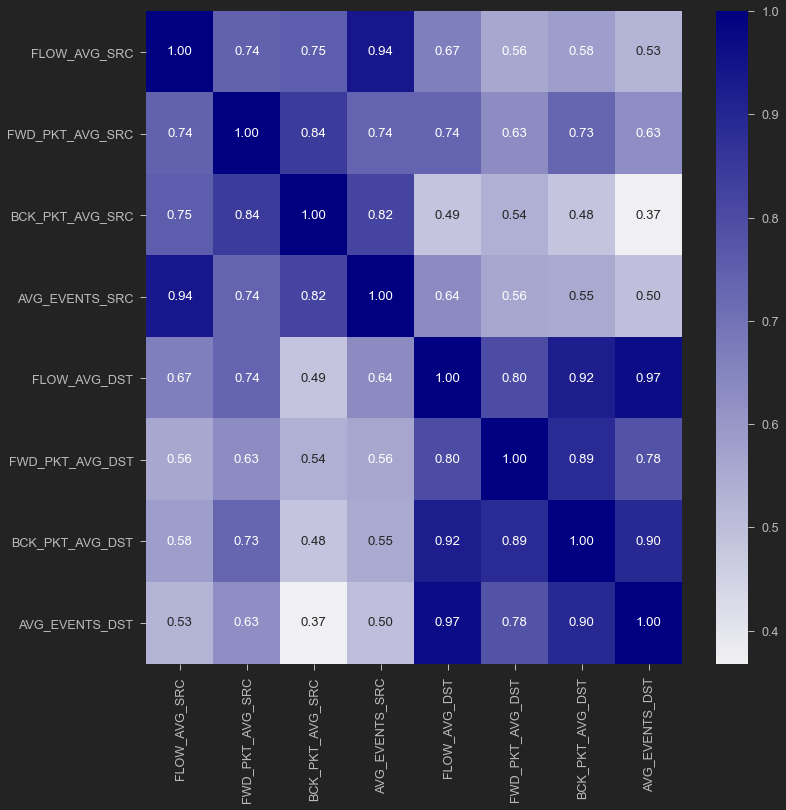

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))
pal = sns.light_palette("navy", as_cmap=True)
sns.heatmap(daily_agg_df.corr(), annot=True, fmt='.2f', cmap=pal);

In general, these datapoints are relatively correlated (closer to 1 or -1). I try to avoid using variables that are correlated with one another for a machine learning algorithm. I often use this example: If we are predicting rent prices in NYC, putting dollar per sq.ft and dollar per sq.cm would be redundant as they will be highly correlated. The model would 'double count' what should be one datapoint. 

We'll use Principal Component Analysis, which will tell us how many variables to use, and we will scale & compress our data to fit the appropriate number of components.

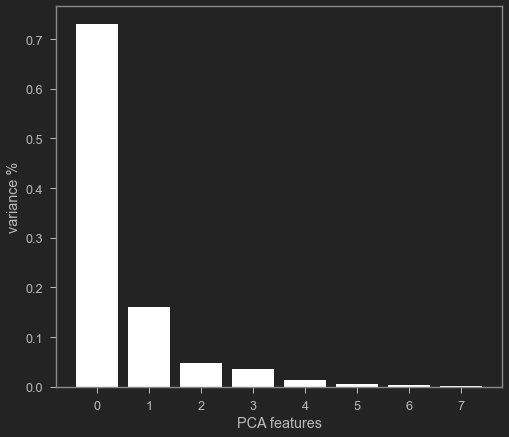

In [28]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(daily_agg_df.drop(['IP'], axis = 1))
# Create a PCA instance
pca = PCA(n_components=8) # we have 8 datapoints
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='white')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

The way to interpret the graph above is that 3 components can explain 95% of the variance in our data. Now that we know how many components to use, let's see how many clusers are appropriate for this dataset.

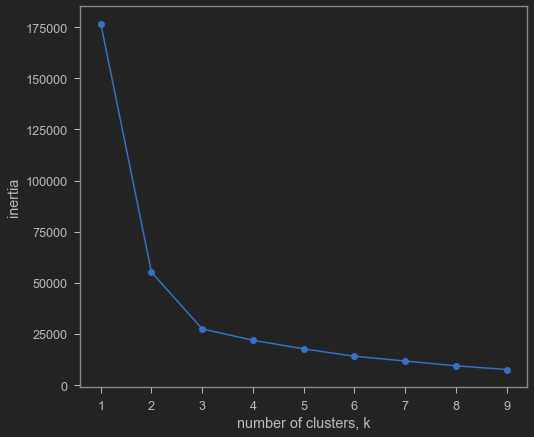

In [29]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The "elbow" as desribed in other projects is at 3, so we will group our data into 3 clusters.

In [30]:
#Kmeans clustering on our data
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 39)
kmeans.fit(PCA_components)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=39, tol=0.0001, verbose=0)

In [31]:
kmeans_df = daily_agg_df.copy()
kmeans_df['kmeans_cluster'] = kmeans.labels_

In [32]:
kmeans_df['kmeans_cluster'].value_counts()

0    23500
2        7
1        6
Name: kmeans_cluster, dtype: int64

In [33]:
kmeans_df.groupby(['kmeans_cluster']).mean()

,FLOW_AVG_SRC,FWD_PKT_AVG_SRC,BCK_PKT_AVG_SRC,AVG_EVENTS_SRC,FLOW_AVG_DST,FWD_PKT_AVG_DST,BCK_PKT_AVG_DST,AVG_EVENTS_DST
kmeans_cluster,,,,,,,,
0,5.680431e+08,1.410542e+03,1.594346e+03,17.666144,4.369906e+08,1.729564e+03,1.516942e+03,22.750258
1,3.780968e+11,1.999113e+06,8.588346e+05,17141.222222,1.158048e+12,1.858344e+06,2.787015e+06,39795.944444
2,5.586608e+11,1.684498e+06,2.382643e+06,31853.261905,2.931207e+11,7.841709e+05,6.369892e+05,4530.785714


So we have successfully clustered our data into 3 groups. This is certainly not the outcome I was hoping for, but that's the way things go in the data science world. The data doesn't care if you have a plan or not. It's interesting that the group sizes are 23500, 7, and 6. For a security prioritization process, this might be really interesting since there are only a handful (13) of nodes that account for 2 of our 3 clusters.

Let's take a look at our averages per cluster and try to categorize them.
 
 0 - Certainly this one has an extremely small event 'footprint.' The other 2 clusters have thousands of events, on average. This cluser only has an average of 18/23. We will call this low traffic.
 
 1 - This cluser averages 40K destination events daily, but as stated above, only averages half of the source events. This will be labeled as high traffic destination.
 
 2 - It averages far fewer destination events than cluster 2, but the average source events is nearly double that of cluster 2. We will call this high traffic source 
 
 


In [34]:
kmeans_df['Label'] = kmeans_df['kmeans_cluster'].map({0:'Low traffic',
                        1:'High Traffic - Dest',
                        2:'High Traffic - Source'})

In [35]:
kmeans_df

,IP,FLOW_AVG_SRC,FWD_PKT_AVG_SRC,BCK_PKT_AVG_SRC,AVG_EVENTS_SRC,FLOW_AVG_DST,FWD_PKT_AVG_DST,BCK_PKT_AVG_DST,AVG_EVENTS_DST,kmeans_cluster,Label
0,10.120.1.191,47988.0,50.0,33.0,14.0,2664.0,1.0,2.0,1.0,0,Low traffic
1,10.130.1.139,15318.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0,Low traffic
2,10.130.10.101,1423184.0,25.0,34.0,5.0,21587.0,22.0,0.0,6.0,0,Low traffic
3,10.130.10.158,14842.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0,0,Low traffic
4,10.130.10.176,13242.0,5.0,7.0,1.0,1.0,2.0,0.0,1.0,0,Low traffic
...,...,...,...,...,...,...,...,...,...,...,...
23508,98.142.101.50,0.0,0.0,0.0,0.0,14294894.0,849.0,1366.0,84.0,0,Low traffic
23509,98.158.146.3,0.0,0.0,0.0,0.0,3334592.0,7.0,9.0,2.0,0,Low traffic
23510,99.198.101.26,0.0,0.0,0.0,0.0,760833.0,19.0,23.0,2.0,0,Low traffic
23511,99.198.108.197,0.0,0.0,0.0,0.0,61850973.0,16.0,13.0,2.0,0,Low traffic


Now we have all of our nodes clustered and labeled. Let's explore Python's NetworkX package and visualize this data.

In [36]:
#Let's see the number of unique connections
netflow_df

,Source.IP,Destination.IP,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets
0,172.19.1.46,10.200.7.7,2017-04-26,45523,22,55
1,10.200.7.7,172.19.1.46,2017-04-26,1,2,0
2,50.31.185.39,10.200.7.217,2017-04-26,1,3,0
3,50.31.185.39,10.200.7.217,2017-04-26,217,1,3
4,192.168.72.43,10.200.7.7,2017-04-26,78068,5,0
...,...,...,...,...,...,...
3577291,98.138.79.73,10.200.7.199,2017-05-15,2290821,5,4
3577292,98.138.79.73,10.200.7.217,2017-05-15,24,5,0
3577293,98.138.79.73,10.200.7.218,2017-05-15,2591653,6,5
3577294,98.138.79.73,10.200.7.195,2017-05-15,2622421,4,3


In [37]:
netflow_df['source-dest'] = netflow_df['Source.IP'] + '-' + netflow_df['Destination.IP']

C:\Users\M\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
netflow_df['source-dest'].nunique()

67212

I think visualizing this network with 67,000 unique edges will not add much value. Also, if this project were to be performed at a real organization, there would be tens of thousands of nodes, if not more. This could cause some real performance issues. Since the clusters provided us with such interesting and unexpected results, let's just look at connections where one of the nodes is in the high traffic clusters and see if that reduces the noise.

In [39]:
#We just need the source and desintation IPs, and their respective labels.
#We also just need the events that had one of the IPs within the 2 high traffic clusters
IP_df = kmeans_df[['IP', 'Label']].drop_duplicates()
IP_df = IP_df[IP_df['Label'] != 'Low traffic']

In [40]:
IP_df

,IP,Label
53,10.200.7.194,High Traffic - Source
54,10.200.7.195,High Traffic - Source
55,10.200.7.196,High Traffic - Source
56,10.200.7.199,High Traffic - Source
57,10.200.7.217,High Traffic - Source
58,10.200.7.218,High Traffic - Source
59,10.200.7.4,High Traffic - Dest
60,10.200.7.5,High Traffic - Dest
61,10.200.7.6,High Traffic - Dest
62,10.200.7.7,High Traffic - Dest


In [41]:
#ht = high traffic
ht_netflow_df = netflow_df[(netflow_df['Source.IP'].isin(IP_df['IP'])) | (netflow_df['Destination.IP'].isin(IP_df['IP']))]

In [42]:
ht_netflow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577292 entries, 0 to 3577295
Data columns (total 7 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Source.IP               object
 1   Destination.IP          object
 2   Timestamp               object
 3   Flow.Duration           int64 
 4   Total.Fwd.Packets       int64 
 5   Total.Backward.Packets  int64 
 6   source-dest             object
dtypes: int64(3), object(4)
memory usage: 218.3+ MB


In [43]:
netflow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577296 entries, 0 to 3577295
Data columns (total 7 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Source.IP               object
 1   Destination.IP          object
 2   Timestamp               object
 3   Flow.Duration           int64 
 4   Total.Fwd.Packets       int64 
 5   Total.Backward.Packets  int64 
 6   source-dest             object
dtypes: int64(3), object(4)
memory usage: 191.0+ MB


Once again, you never know what to expect when exploring a dataset. As common sense would dictate, all events in this dataset have at least one of our 13 high traffic nodes. At least this validates our clustering outcome. We'll keep moving forward with all events and see what happens. But, for the sake of performance I will only keep unique source-destination combinations.

In [44]:
ht_netflow_df = ht_netflow_df[['Source.IP', 'Destination.IP']].drop_duplicates()

In [45]:
ht_netflow_df.info

<bound method DataFrame.info of               Source.IP Destination.IP
0           172.19.1.46     10.200.7.7
1            10.200.7.7    172.19.1.46
2          50.31.185.39   10.200.7.217
4         192.168.72.43     10.200.7.7
5            10.200.7.6    172.19.1.56
...                 ...            ...
3569896  98.139.180.180   10.200.7.195
3569898   98.139.21.169   10.200.7.195
3571498      10.200.7.4  192.168.60.50
3571652      10.200.7.4  192.168.90.47
3574216   192.168.10.50     10.200.7.8

[67211 rows x 2 columns]>

In [46]:
#We will join this to our dataframe with the 13 high traffic nodes. If the label is NA then we know it is a low traffic node and we can adjust accordingly.
netflow_event_labels = pd.merge(ht_netflow_df, IP_df, left_on = 'Source.IP', right_on='IP', how='left')
netflow_event_labels = netflow_event_labels.rename(columns = {'Label':'source.label'})

In [47]:
netflow_event_labels = pd.merge(netflow_event_labels, IP_df, left_on = 'Destination.IP', right_on='IP', how='left')
netflow_event_labels = netflow_event_labels.rename(columns = {'Label':'dest.label'})

In [48]:
netflow_event_labels.drop(['IP_x', 'IP_y'], axis = 1, inplace = True)

In [49]:
netflow_event_labels

,Source.IP,Destination.IP,source.label,dest.label
0,172.19.1.46,10.200.7.7,NaN,High Traffic - Dest
1,10.200.7.7,172.19.1.46,High Traffic - Dest,NaN
2,50.31.185.39,10.200.7.217,NaN,High Traffic - Source
3,192.168.72.43,10.200.7.7,NaN,High Traffic - Dest
4,10.200.7.6,172.19.1.56,High Traffic - Dest,NaN
...,...,...,...,...
67206,98.139.180.180,10.200.7.195,NaN,High Traffic - Source
67207,98.139.21.169,10.200.7.195,NaN,High Traffic - Source
67208,10.200.7.4,192.168.60.50,High Traffic - Dest,NaN
67209,10.200.7.4,192.168.90.47,High Traffic - Dest,NaN


In [50]:
#Let's run 1000 events and see what it looks like
events = netflow_event_labels.copy()
events = events.sample(1000)

In [51]:
G = nx.Graph()

In [52]:
G = nx.from_pandas_edgelist(events, 'Source.IP', 'Destination.IP')

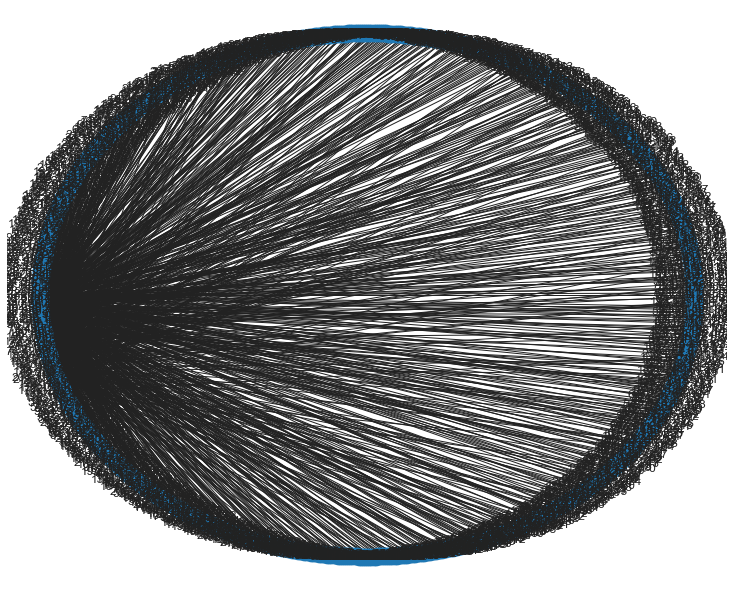

In [53]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

This is about as helpful as I expected this to be. Let's try to look at the number of connections per node and filter out nodes based on how many events they're a part of.

In [54]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])

s = pd.Series(leaderboard, name='connections')

connections_df = s.to_frame().sort_values('connections', ascending=False)

In [55]:
connections_df

,connections
10.200.7.217,146
10.200.7.218,139
10.200.7.195,135
10.200.7.196,132
10.200.7.199,120
...,...
38.99.237.30,1
96.43.151.189,1
216.58.222.82,1
23.32.6.216,1


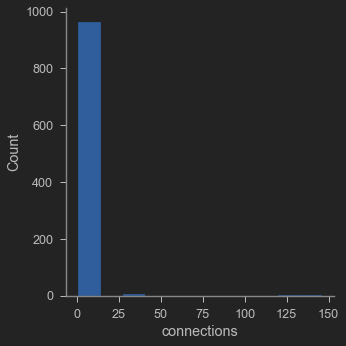

In [56]:
sns.displot(connections_df, x="connections")

In [57]:
connections_df.value_counts()

connections
1              931
2               32
35               2
146              1
139              1
135              1
132              1
120              1
119              1
40               1
34               1
32               1
31               1
3                1
dtype: int64

Unfortunately, it is appearing that NetworkX has proven to be more appropriate and more powerful than machine learning for this specific dataset. Had we started with NetworkX, we would have realized the nature of this data much quicker and with much more clarity. 

928 nodes have 1 unique connection (remember, this is only a sample of our data). Since that is extremely common, we will try to filter out some noise by removing nodes with only 1 connection.

In [58]:
connections_df.reset_index(inplace = True)
connections_df = connections_df.rename(columns = {'Label':'dest.label'})

In [59]:
connections_df = connections_df[connections_df['connections'] > 1]

In [60]:
events = events[(events['Source.IP'].isin(connections_df['index'])) & (events['Destination.IP'].isin(connections_df['index']))]

In [61]:
events

,Source.IP,Destination.IP,source.label,dest.label
57375,10.200.7.7,192.168.110.10,High Traffic - Dest,NaN
45879,10.200.7.9,192.168.10.43,High Traffic - Dest,NaN
10822,104.91.132.45,10.200.7.195,NaN,High Traffic - Source
16504,162.125.4.3,10.200.7.195,NaN,High Traffic - Source
31924,10.200.7.218,174.129.254.127,High Traffic - Source,NaN
...,...,...,...,...
50589,23.9.54.218,10.200.7.217,NaN,High Traffic - Source
32963,192.168.72.48,10.200.7.7,NaN,High Traffic - Dest
14250,10.200.7.199,63.251.210.243,High Traffic - Source,NaN
16416,10.200.7.9,192.168.180.7,High Traffic - Dest,NaN


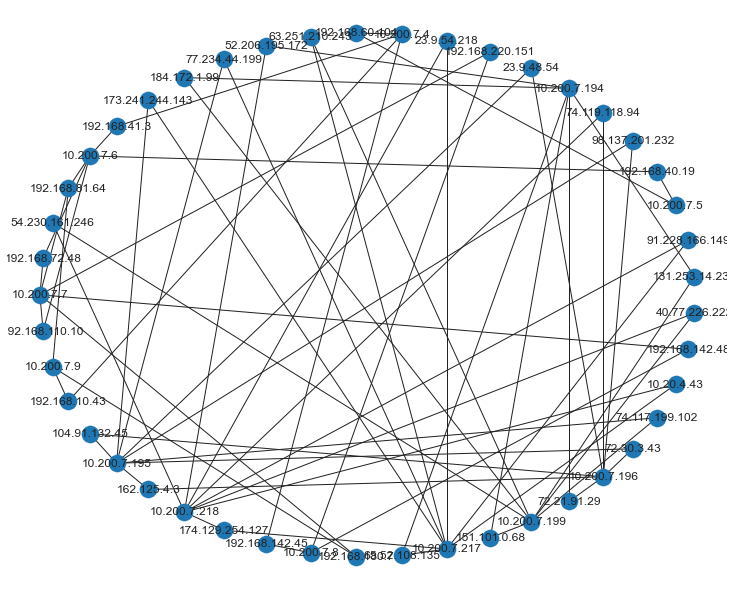

In [62]:
G = nx.from_pandas_edgelist(events, 'Source.IP', 'Destination.IP')
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

Now we're getting somewhere! Let's color the nodes by the clusters we created earlier.

In [63]:
events.head()

,Source.IP,Destination.IP,source.label,dest.label
57375,10.200.7.7,192.168.110.10,High Traffic - Dest,NaN
45879,10.200.7.9,192.168.10.43,High Traffic - Dest,NaN
10822,104.91.132.45,10.200.7.195,NaN,High Traffic - Source
16504,162.125.4.3,10.200.7.195,NaN,High Traffic - Source
31924,10.200.7.218,174.129.254.127,High Traffic - Source,NaN


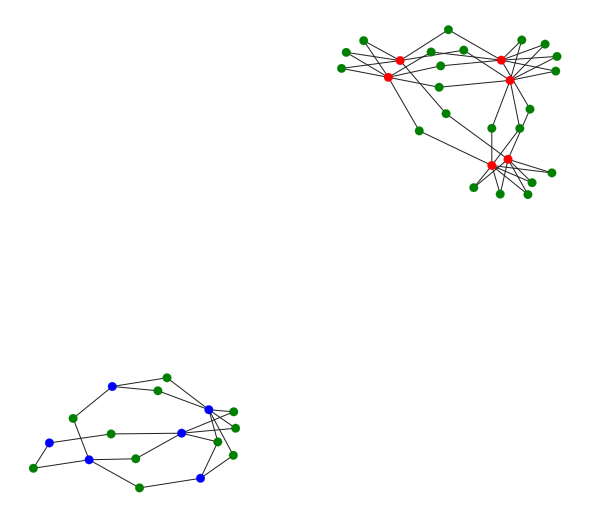

In [64]:
color_map = []
for node in G:
    if node in IP_df['IP'][IP_df['Label'] == 'High Traffic - Source'].tolist(): #Remeber this is just the high traffic nodes
        color_map.append('red')
    elif node in IP_df['IP'][IP_df['Label'] == 'High Traffic - Dest'].tolist():
        color_map.append('blue')
    else:
        color_map.append('green')   


nx.draw(G, node_color = color_map, node_size = 75)

Now we are finally piecing things togther. Blue nodes are the *High Traffic - Dest*. Red nodes are *High Traffic - Source*. Green nodes are in the low traffic cluster.
Let's perform the same actions on the full dataset, exlcuding nodes with only one connection. We'll really start from scratch here and use the original dataset.

In [65]:
all_events = netflow_df.copy()

In [66]:
G_all = nx.from_pandas_edgelist(all_events, 'Source.IP', 'Destination.IP')

In [67]:
all_conns = {}
for x in G_all.nodes:
 all_conns[x] = len(G_all[x])

s = pd.Series(all_conns, name='connections')

all_cons_df = s.to_frame().sort_values('connections', ascending=False)

In [68]:
all_cons_df

,connections
10.200.7.218,8558
10.200.7.217,8148
10.200.7.195,7672
10.200.7.199,7571
10.200.7.196,7436
...,...
185.152.64.150,1
52.222.217.159,1
52.15.122.245,1
146.20.133.3,1


In [69]:
all_cons_df.reset_index(inplace=True)

In [70]:
significant_conns = all_cons_df[all_cons_df['connections'] > 1]

In [71]:
all_events_filtered = all_events[(all_events['Source.IP'].isin(significant_conns['index'])) & (all_events['Destination.IP'].isin(significant_conns['index']))]

In [72]:
#We removed 92,943 events by looking for nodes with at least 2 connections
print(len(all_events_filtered))
print(len(netflow_df))
print(len(netflow_df) - len(all_events_filtered))

3484353
3577296
92943


In [73]:
#Still having performance issues trying to display the graph so I will have to reduce the amount of nodes. Unfortunately, my processing power is limited to my laptop.
G_significant = nx.from_pandas_edgelist(all_events_filtered.sample(100000), 'Source.IP', 'Destination.IP')

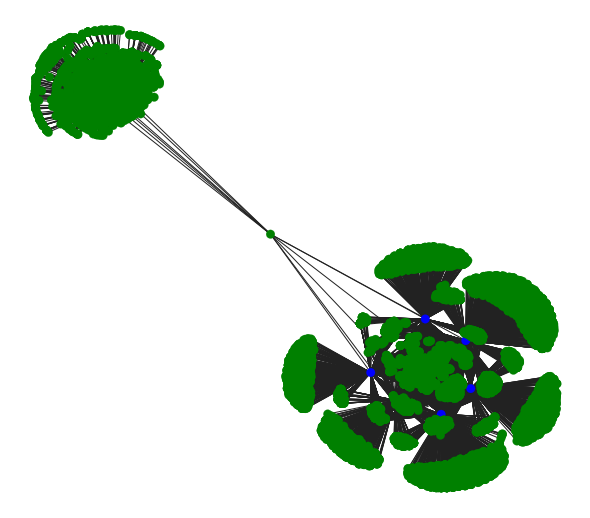

In [76]:
#Below is the code used to create this graph. Due to performance issues, as I performed this analysis I only ran the code once and took a screenshot of the output.
#color_map_all = []
#for node in G_significant:
    #if node in IP_df['IP'][IP_df['Label'] == 'High Traffic - Source'].tolist(): #Remeber this is just the high traffic nodes
        #color_map_all.append('red')
    #elif node in IP_df['IP'][IP_df['Label'] == 'High Traffic - Dest'].tolist():
        #color_map_all.append('blue')
    #else:
        #color_map_all.append('green')   
#nx.draw(G_significant, node_color = color_map_all, node_size = 75)
Image(filename='networkx_graph.png') 

Wow! I wish this was a depiction of the entire dataset, but 100,000 events was already taking a significant amount of time to run. So what did we learn by looking at this?

I'll start with an assumption. I'm guessing that there are red nodes hidden in the sea of green. 

It's clear that the blue nodes have an extremely high centrality. They have countless edges with many, many nodes. Circling back to adding a security context to this, we would definitely want to prioritize these nodes (or atleast identify and evaulate them first). 

What I find really interesting about this is that green node in the center. If this were a depiction of the entire network, and not just a sample, this node acts as a gatekeeper for a huge portion of the network. Even though, based on our metrics, this qualified as low traffic, this node clearly serves a huge role in the network architecture. As a malicious actor, gaining control of that node is the key to the castle. 

Since we've already identified our high traffic nodes, the one final node we need to identify is the green one linking the two network segments together.

In [93]:
#Removing high traffic nodes and looking for a node with 9+ connections
all_cons_df[(~all_cons_df['index'].isin(IP_df['IP'])) & (all_cons_df['connections'] >= 9)]

,index,connections
12,10.200.1.118,12


It looks like we found the node of interest. Alternatively, we could have also labeled the visual. The only caveat would be that the noise from the labels within the network segments would have been extremely congested.

### Recap

We took a dataset of netflow events and turned it into a visualization of the network, colored by our clustering algorithm which grouped each node based on its daily aggregate event characteristics. 

We identified notes which would need to be prioritized (or at least inspected) when performing cyber security-related protocols. Additionally, thanks to NetworkX, we identified a node that had the characteristics of a low-traffic node, but served a huge role in the overall network architecture. 

We probably could have used NetworkX alone to identify and highlight high traffic nodes. But with a more realistic and complete dataset, it would be harder to discern where to draw the line for high traffic vs. medium vs. low. It would not be as black and white as this dataset appeared to be. If I had to continue working on this to really understand the network on a deep level (which I may do in a future project), I would look at specific segments of the network (i.e. take the group of green nodes attached to a specific blue node and inspect the edges. 

Edges are one more piece of information that is really insightful that we would typically have access to. The edges (lines) between the nodes can also carry a weight. We can see how many instances there are (how many events between A & B), and we can also see the direction. Direction is a huge piece of information needed. This dataset doesn't have as much directional information as I have seen in the past. Similar datasets may have an edge "relationship" rather than just an event between A & B. For example, AdminTo, HasSession, etc. This really helps identify vulnerabilities in the network.

If node A is AdminTo node B, node A is much more important to us because it has a higher-privilege (as I explained earlier). We really only had access to node-level data for this project, but I just wanted to discuss the importance of edges/relationships.

Overall, it's always extremely insightful and rewarding the combine a machine learning algorithm with a data visualization. We turned hundreds of thousands of raw events into an actionable list and visual.
